In [7]:
import matplotlib.pyplot as plt

from spice import convert_dataset, plot_session
from spice.resources.bandits import AgentNetwork, get_update_dynamics

from weinhardt2025.benchmarking.benchmarking_qlearning import QLearning

In [2]:
dataset = convert_dataset(
    file='weinhardt2025/data/eckstein2022/eckstein2022.csv',
)

n_participants = len(dataset.xs[..., -1].unique())
n_actions = dataset.ys.shape[-1]

print(dataset.xs.shape)

torch.Size([292, 156, 7])


In [ ]:
q_learning = QLearning(
    n_actions=n_actions,
    n_participants=n_participants,
    beta_reward=3.0,
    alpha_reward=0.5,
    alpha_penalty=0.3,
    forget_rate=0.2,
    beta_choice=1.5,
)

agent_q_learning = AgentNetwork(q_learning, n_actions=n_actions, use_sindy=True)

In [4]:
agent_q_learning.model.print_spice_model(participant_id=0)

value_reward_chosen[t+1] = 0.7 value_reward_chosen[t] + 1.5 reward + -0.2 value_reward_chosen*reward 
value_reward_not_chosen[t+1] = 0.8 value_reward_not_chosen[t] 
value_choice[t+1] = 1.5 choice 


In [18]:
q_learning.get_modules()

['value_reward_chosen', 'value_reward_not_chosen', 'value_choice']

In [19]:
q_learning.sindy_candidate_terms['value_reward_chosen']

['1',
 'value_reward_chosen',
 'reward',
 'value_reward_chosen^2',
 'value_reward_chosen*reward',
 'reward^2']

In [22]:
q_learning.sindy_coefficients['value_reward_chosen'].shape

torch.Size([292, 1, 1, 6])

In [ ]:
participant_id = 0
q_learning.sindy_coefficients['value_reward_chosen'][participant_id, 0, 0]

tensor([ 0.0000, -0.3000,  1.5000,  0.0000, -0.2000, -0.0000])

In [5]:
values, choice_probs, agent_q_learning = get_update_dynamics(dataset.xs[0], agent_q_learning)
logits, state_values = values
value_reward = state_values['value_reward']
value_choice = state_values['value_choice']

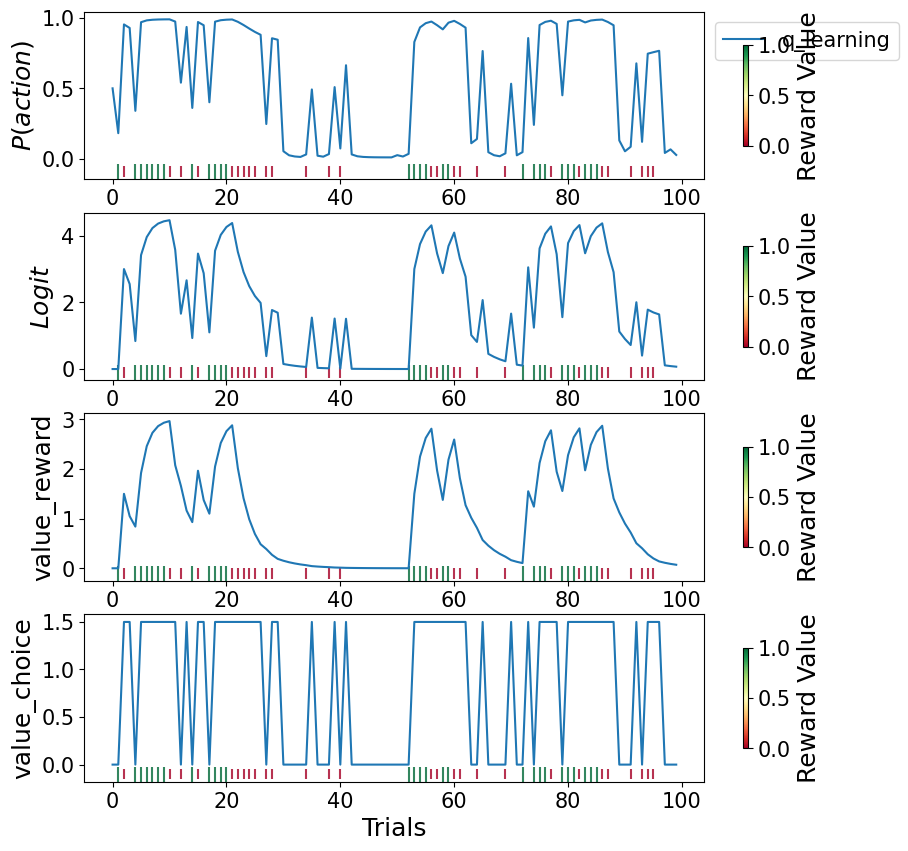

In [17]:
fig, axs = plot_session({'q_learning': agent_q_learning}, dataset.xs[0], signals_to_plot=['value_reward', 'value_choice'])
plt.show()